In [1]:
!nvidia-smi

Mon Jul 22 16:01:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# import os

# directory = "pubmed-rct-master/PubMed_200k_RCT_numbers_replaced_with_at_sign"
# files = os.listdir(directory)
# for file in files:
#     print(file)

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# Start our experiments using the 200k dataset with numbers replaced be @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

## Now we will preprocess the data

We will try to visualize as many things we can

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [7]:
# Read the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

## Change the look of data
We will make dictionaries

```python
[{
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': "The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n",
    'total_lines': 10,
},
    ...]

In [9]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence
    number the target line is
    """
    input_lines = get_lines(filename)   # get all lines from filename
    abstract_lines = ""     # Create an empty abstract
    abstract_samples = []       # Create an empty line of abstracts

    # look through each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # check to see if it is the ID line
            abstract_id = line
            abstract_lines = ""     # reset the abstract string is the line is an ID line

        elif line.isspace():        # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines()   # split abstract into seperate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # create an emoty dictionary for each line
                target_text_split = abstract_line.split("\t")   # Split target label from text
                line_data["target"] = target_text_split[0]      # Get target label
                line_data["text"] = target_text_split[1].lower()    # Get target text and lower it
                line_data["line_number"] = abstract_line_number     # What number line does the line appear in the abstracr
                line_data["total_lines"] = len(abstract_line_split) - 1     # How many total lines are there in the target abstract
                abstract_samples.append(line_data)      # Add line data to abstract sampple list
        else:   # if the above conditions aren't fullfilled, the line to contains a labelled sentence
            abstract_lines += line

    return abstract_samples


In [10]:
# Check the time
import time
start_time = time.time()

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Lengths: {len(train_samples)}, {len(val_samples)}, {len(test_samples)}")


Execution time: 2.56 seconds
Lengths: 180040, 30212, 30135


In [11]:
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Now our data is in the form of a list of dictionaries. Now we can turn it into a DataFrame

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in the training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

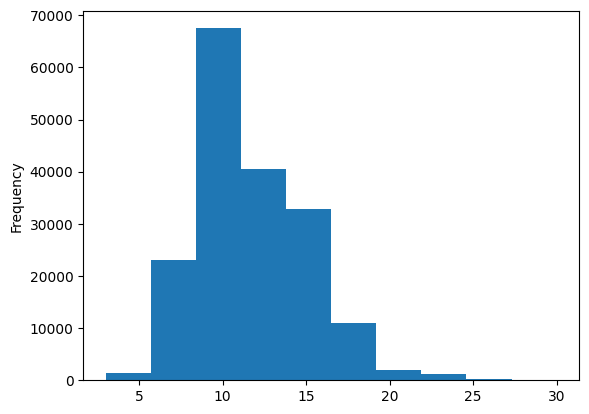

In [14]:
# Check the length of different lines
train_df.total_lines.plot.hist()

## Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models requires numeric labels)

In [17]:
# One hot encode
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number fo classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Making a baseline model with Naive Bayes

In [20]:
# Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (text) for deep sequence models

We need to create vectorization and embeddings layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [27]:
# Checking the average length of each sentence
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

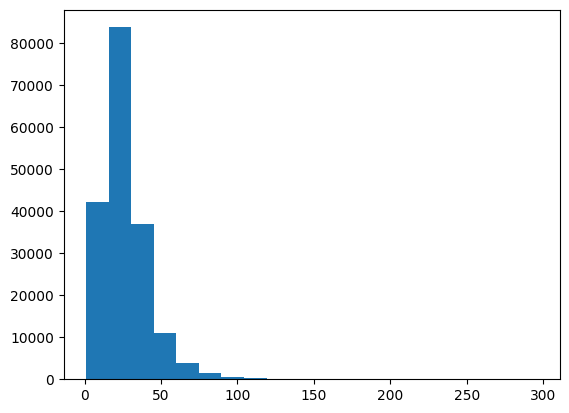

In [28]:
# visualizing the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [29]:
# How long of a sentence length covers 98% of examples
output_seq_len = int(np.percentile(sent_lens, 99))
output_seq_len

80

In [30]:
# Maxmimum sequence length on training set
max(sent_lens)

296

## Create text vectorizer layer

We want to make a layer which maps our words to numbers

In [54]:
max_tokens = 68000     #(taken from https://arxiv.org/pdf/1710.06071)

In [55]:
# Create a text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,  # No of words in vocabulary
                                    output_sequence_length = output_seq_len)    # Desired output length of vectorized sequence


In [56]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [57]:
# Test out our vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the intervention consisted of an ips supported employment service hosted by a community mental health team .

Length of text: 17

Vectorized text: [[    2    38  1007     4    26  4885  1740  2538  1138 38237    22     8
    613   486    97  1661     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]


In [58]:
# How many words in our training vocabulary
rct_200k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Numbers of words in vocab: {len(rct_200k_text_vocab)}")
print(f"Most common words in the vocab: {rct_200k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_200k_text_vocab[-5:]}")

Numbers of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [59]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 80,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [60]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_200k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [61]:
# Show an example embedding
print(f"sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embeddinng): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

sentence before vectorization: 
 the intervention consisted of an ips supported employment service hosted by a community mental health team .

Sentence after vectorization (before embeddinng): 
 [[    2    38  1007     4    26  4885  1740  2538  1138 38237    22     8
    613   486    97  1661     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[ 0.03905983 -0.03312408 -0.04669545 ... -0.00878837  0.00983815
   -0.02760061]
  [ 0.04002226 -0.00052329  0.01650539 ...  0.04170344  0.00928459
    0.02795731]
  [ 0.04086632 -0.0120507  -0.0392675  ... -0.0326243   0.01922883
    0.04094491]
  ...
  [-0.0089146  -0.0139407

## Creating datasets to make data load faster

In [62]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [63]:
# Take the TensorsliceDataset and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [64]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 80)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 80, 128)           8299648   
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 128)           82048     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [65]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.3*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.3 * len(valid_dataset)))


Epoch 1/5
1688/1688 [==============================] - 32s 18ms/step - loss: 0.7366 - accuracy: 0.7180 - val_loss: 0.5972 - val_accuracy: 0.7884
Epoch 2/5
1688/1688 [==============================] - 13s 8ms/step - loss: 0.5910 - accuracy: 0.7895 - val_loss: 0.5505 - val_accuracy: 0.8060
Epoch 3/5
1688/1688 [==============================] - 13s 8ms/step - loss: 0.5494 - accuracy: 0.8062 - val_loss: 0.5478 - val_accuracy: 0.8025
Epoch 4/5
 563/1688 [=========>....................] - ETA: 7s - loss: 0.5454 - accuracy: 0.8062

1688/1688 [==============================] - 5s 3ms/step - loss: 0.5454 - accuracy: 0.8062 - val_loss: 0.5341 - val_accuracy: 0.8091


In [66]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5346 - accuracy: 0.8090


[0.5345838069915771, 0.8089500665664673]

In [67]:
# Make predictions (our model predicts prediction probability for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 3ms/step


(array([[5.19723058e-01, 1.05618589e-01, 1.24680504e-01, 1.72764152e-01,
         7.72137567e-02],
        [5.47436357e-01, 1.96964249e-01, 8.74269940e-03, 2.26891726e-01,
         1.99648961e-02],
        [1.92937925e-01, 5.86496294e-03, 1.26348319e-03, 7.99893200e-01,
         4.04208404e-05],
        ...,
        [7.20784556e-06, 1.47687009e-04, 1.81655271e-03, 5.24582538e-06,
         9.98023272e-01],
        [1.21909015e-01, 3.45723212e-01, 1.64268225e-01, 7.81373829e-02,
         2.89962202e-01],
        [4.05402742e-02, 9.31339443e-01, 2.17611473e-02, 1.27500016e-03,
         5.08412346e-03]], dtype=float32),
 (30212, 5))

In [68]:
# COnvert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [69]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [70]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.89500860585198,
 'precision': 0.8062180455500283,
 'recall': 0.8089500860585198,
 'f1': 0.8051398954671345}

In [71]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [72]:
# Save checkpoint
model_1.save('model_1_naive_bayes')

In [73]:
# Load checkpoint
from tensorflow.keras.models import load_model
model_1 = load_model('model_1_naive_bayes')

# Model 2: Feature extraction with pretrained token embeddings

In [74]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encorder")

In [75]:
# Test our pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 to compare the difference in anthropometric measurements of rural chinese infants and toddlers @ to @ months of age who received a daily supplement of meat or cereal for @ months .
Sentence after embedding:
[-0.03796971 -0.0242381  -0.03524832 -0.02122649 -0.09079968  0.01952534
 -0.02844069 -0.0412802  -0.03842737  0.00036169  0.0559225   0.07666236
 -0.02798977 -0.03953298 -0.0906198   0.01504502 -0.09068699 -0.02988772
  0.00109144 -0.00850739  0.08561673  0.03142512 -0.0469651   0.05297924
  0.03311467  0.06147819  0.02580607  0.07936511 -0.03494391 -0.00434409]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [76]:
# Define feature extraction model TF HUB layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encorde  (None, 512)               256797824 
 r (KerasLayer)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [77]:
history_model_2 = model_2.fit(train_dataset, epochs=5,
                              steps_per_epoch=int(0.3 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.3 * len(valid_dataset)))


Epoch 1/5
1688/1688 [==============================] - 30s 14ms/step - loss: 0.8115 - accuracy: 0.6889 - val_loss: 0.7310 - val_accuracy: 0.7171
Epoch 2/5
1688/1688 [==============================] - 22s 13ms/step - loss: 0.7186 - accuracy: 0.7241 - val_loss: 0.6792 - val_accuracy: 0.7395
Epoch 3/5
1688/1688 [==============================] - 23s 14ms/step - loss: 0.6770 - accuracy: 0.7432 - val_loss: 0.6633 - val_accuracy: 0.7457
Epoch 4/5
 559/1688 [========>.....................] - ETA: 14s - loss: 0.6650 - accuracy: 0.7490

1688/1688 [==============================] - 10s 6ms/step - loss: 0.6658 - accuracy: 0.7487 - val_loss: 0.6546 - val_accuracy: 0.7502


In [78]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 13ms/step - loss: 0.6564 - accuracy: 0.7494


[0.6563908457756042, 0.7494041919708252]

In [85]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[3.92859310e-01, 4.88094747e-01, 4.32589848e-04, 1.12474486e-01,
        6.13894686e-03],
       [3.27051222e-01, 5.68891227e-01, 2.20192247e-03, 1.00744396e-01,
        1.11123489e-03],
       [5.12110651e-01, 4.01916951e-02, 1.82883535e-02, 3.99818242e-01,
        2.95910612e-02],
       ...,
       [1.00142008e-03, 1.07906002e-03, 2.42567975e-02, 2.01102986e-04,
        9.73461628e-01],
       [4.12361138e-03, 4.08036523e-02, 1.91439033e-01, 9.77162388e-04,
        7.62656569e-01],
       [5.19482009e-02, 8.42796743e-01, 9.66121033e-02, 9.30136011e-04,
        7.71286059e-03]], dtype=float32)

In [86]:
# Make predictins with feature extraction model
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

In [87]:
# Calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 74.94042102475838,
 'precision': 0.7444649474727242,
 'recall': 0.7494042102475837,
 'f1': 0.7446769505395039}

## Model 3: Conv1D with character embeddings

Creating a character level tokenizer

In [90]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

  # Text splitting non character level sequence int characters
  split_chars(random_train_sentence)

In [92]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [94]:
# What is the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

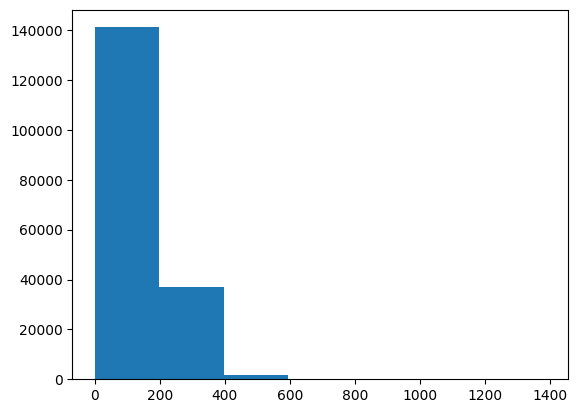

In [95]:
# Check the distribution for our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [96]:
# Find what character leangth covers 99% sequences
output_seq_char_len = int(np.percentile(char_lens, 99))
output_seq_char_len

395

In [97]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [98]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [99]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [100]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [102]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n {vectorized_chars}")
print(f"\n Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
 c o - a d m i n i s t r a t i o n   o f   c y c l o s p o r i n e   w i t h   t i c a g r e l o r   i n c r e a s e d   e x p o s u r e   t o   t i c a g r e l o r   a n d   i t s   a c t i v e   m e t a b o l i t e   a n d   h a d   n o   e f f e c t   o n   c y c l o s p o r i n e   p h a r m a c o k i n e t i c   p a r a m e t e r s   .

Length of random_train_chars: 150

Vectorized chars: 
 [[11  7  5 10 15  4  6  4  9  3  8  5  3  4  7  6  7 17 11 19 11 12  7  9
  14  7  8  4  6  2 20  4  3 13  3  4 11  5 18  8  2 12  7  8  4  6 11  8
   2  5  9  2 10  2 24 14  7  9 16  8  2  3  7  3  4 11  5 18  8  2 12  7
   8  5  6 10  4  3  9  5 11  3  4 21  2 15  2  3  5 22  7 12  4  3  2  5
   6 10 13  5 10  6  7  2 17 17  2 11  3  7  6 11 19 11 12  7  9 14  7  8
   4  6  2 14 13  5  8 15  5 11  7 23  4  6  2  3  4 11 14  5  8  5 15  2
   3  2  8  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [103]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [104]:
# Test our character embedding layer
print(f"Charified text: \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text: 
 c o - a d m i n i s t r a t i o n   o f   c y c l o s p o r i n e   w i t h   t i c a g r e l o r   i n c r e a s e d   e x p o s u r e   t o   t i c a g r e l o r   a n d   i t s   a c t i v e   m e t a b o l i t e   a n d   h a d   n o   e f f e c t   o n   c y c l o s p o r i n e   p h a r m a c o k i n e t i c   p a r a m e t e r s   .

Embedded chars (after vectorization and embedding):
 [[[ 0.03809274  0.00554601 -0.01130713 ...  0.02993469 -0.04813075
    0.02249832]
  [-0.00241909  0.04132667 -0.04340741 ... -0.04051508 -0.03335085
    0.00676297]
  [ 0.03942951 -0.04821789  0.04916966 ...  0.03595972  0.02631715
   -0.03998893]
  ...
  [-0.00436943  0.01379514  0.01600372 ... -0.03512017 -0.00771217
   -0.00455324]
  [-0.00436943  0.01379514  0.01600372 ... -0.03512017 -0.00771217
   -0.00455324]
  [-0.00436943  0.01379514  0.01600372 ... -0.03512017 -0.00771217
   -0.00455324]]]
Character embedding shape: (1, 395, 25)


## Building a Conv1D

In [105]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_Conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [106]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [107]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.3 * len(train_char_dataset)),
                              epochs=5,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.3 * len(val_char_dataset)))


Epoch 1/5
1688/1688 [==============================] - 14s 6ms/step - loss: 1.0252 - accuracy: 0.5924 - val_loss: 0.8443 - val_accuracy: 0.6768
Epoch 2/5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.8146 - accuracy: 0.6887 - val_loss: 0.7616 - val_accuracy: 0.7119
Epoch 3/5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.7531 - accuracy: 0.7139 - val_loss: 0.7033 - val_accuracy: 0.7364
Epoch 4/5
 563/1688 [=========>....................] - ETA: 5s - loss: 0.7275 - accuracy: 0.7189

1688/1688 [==============================] - 4s 2ms/step - loss: 0.7275 - accuracy: 0.7189 - val_loss: 0.7395 - val_accuracy: 0.7170


In [108]:
model_3_preds_probs = model_3.predict(val_char_dataset)
model_3_preds_probs

945/945 [==============================] - 5s 5ms/step


array([[0.22799249, 0.23361944, 0.01316938, 0.4936494 , 0.03156926],
       [0.4497125 , 0.44136813, 0.00270208, 0.0781022 , 0.02811505],
       [0.20979983, 0.04648975, 0.0387874 , 0.69997805, 0.00494494],
       ...,
       [0.00133293, 0.00515388, 0.03268224, 0.00096558, 0.9598654 ],
       [0.02011935, 0.1134133 , 0.19921036, 0.00719909, 0.6600579 ],
       [0.08386572, 0.8642243 , 0.02202315, 0.00786795, 0.02201894]],
      dtype=float32)

In [109]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 4, 1])>

In [110]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 71.51462994836488,
 'precision': 0.71519542299528,
 'recall': 0.7151462994836488,
 'f1': 0.7041908498734715}

## Model 4: Combining pretrained token embeddings + characters embeddings

In [111]:
#1. Setup tokten inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu") (token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Droupout, discused in section 4.2 in paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embedding")



In [112]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 395)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encorde  (None, 512)                  2567978  

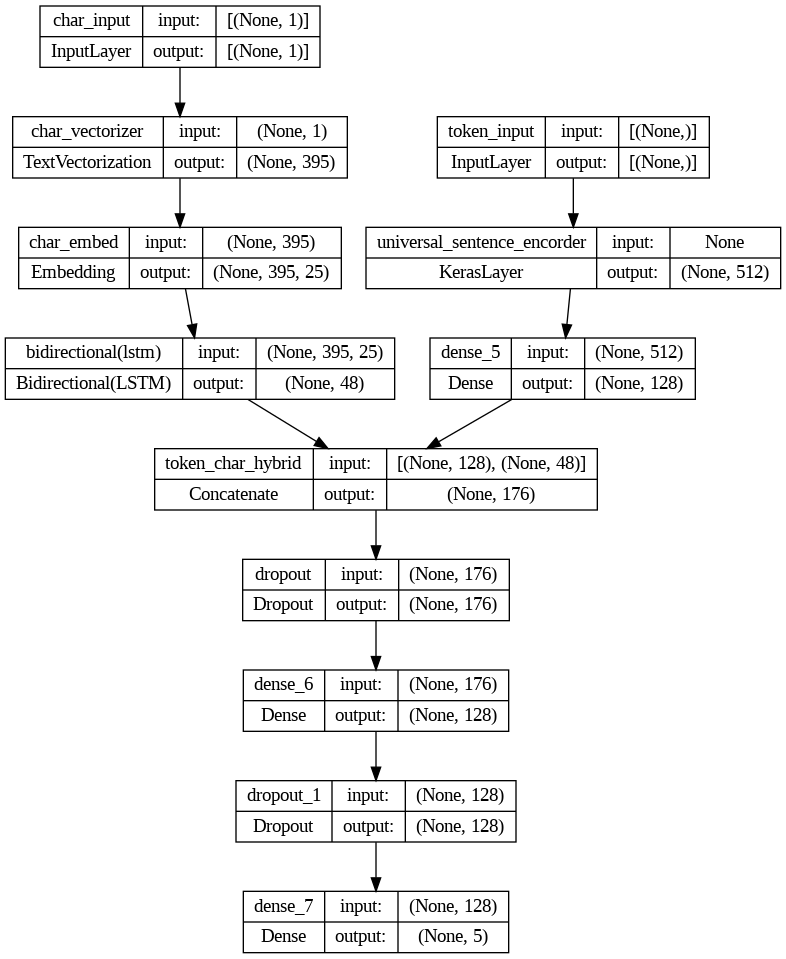

In [113]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [114]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into tf.Data.Dataset

In [115]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [116]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [117]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.3 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.3 * len(val_char_token_dataset)))

Epoch 1/5
1688/1688 [==============================] - 104s 51ms/step - loss: 0.8512 - accuracy: 0.6695 - val_loss: 0.6922 - val_accuracy: 0.7341
Epoch 2/5
1688/1688 [==============================] - 83s 49ms/step - loss: 0.7438 - accuracy: 0.7201 - val_loss: 0.6464 - val_accuracy: 0.7563
Epoch 3/5
1688/1688 [==============================] - 88s 52ms/step - loss: 0.7035 - accuracy: 0.7334 - val_loss: 0.6321 - val_accuracy: 0.7615
Epoch 4/5
 563/1688 [=========>....................] - ETA: 55s - loss: 0.7078 - accuracy: 0.7327

1688/1688 [==============================] - 34s 20ms/step - loss: 0.7078 - accuracy: 0.7327 - val_loss: 0.6194 - val_accuracy: 0.7645


In [118]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 26s 28ms/step - loss: 0.6221 - accuracy: 0.7623


[0.6220540404319763, 0.762346088886261]

In [119]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 26s 22ms/step


In [120]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [121]:
# Get results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.23460876472924,
 'precision': 0.7612161093443218,
 'recall': 0.7623460876472925,
 'f1': 0.7581880390377691}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [122]:
# lines numbers
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

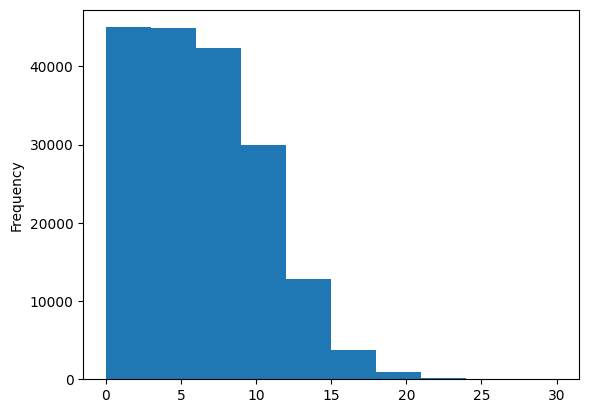

In [123]:
# Check the distrubution of "line_number" column
train_df.line_number.plot.hist()

In [124]:
# Use TensorFloow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [125]:
# Different nummber of lines are there
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

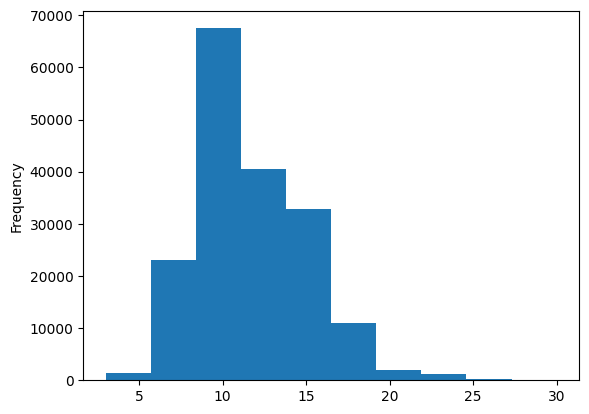

In [126]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [127]:
# Check the coverage of "total_lines" value of 20
np.percentile(train_df.total_lines, 98)


20.0

In [128]:
# Use TensorFlow too create one-hot encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]


(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [137]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the Model (as provided)
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(
    inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="model_5_tribrid_embedding_model"
)

In [138]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 395)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encorde  (None, 512)                  2567978   

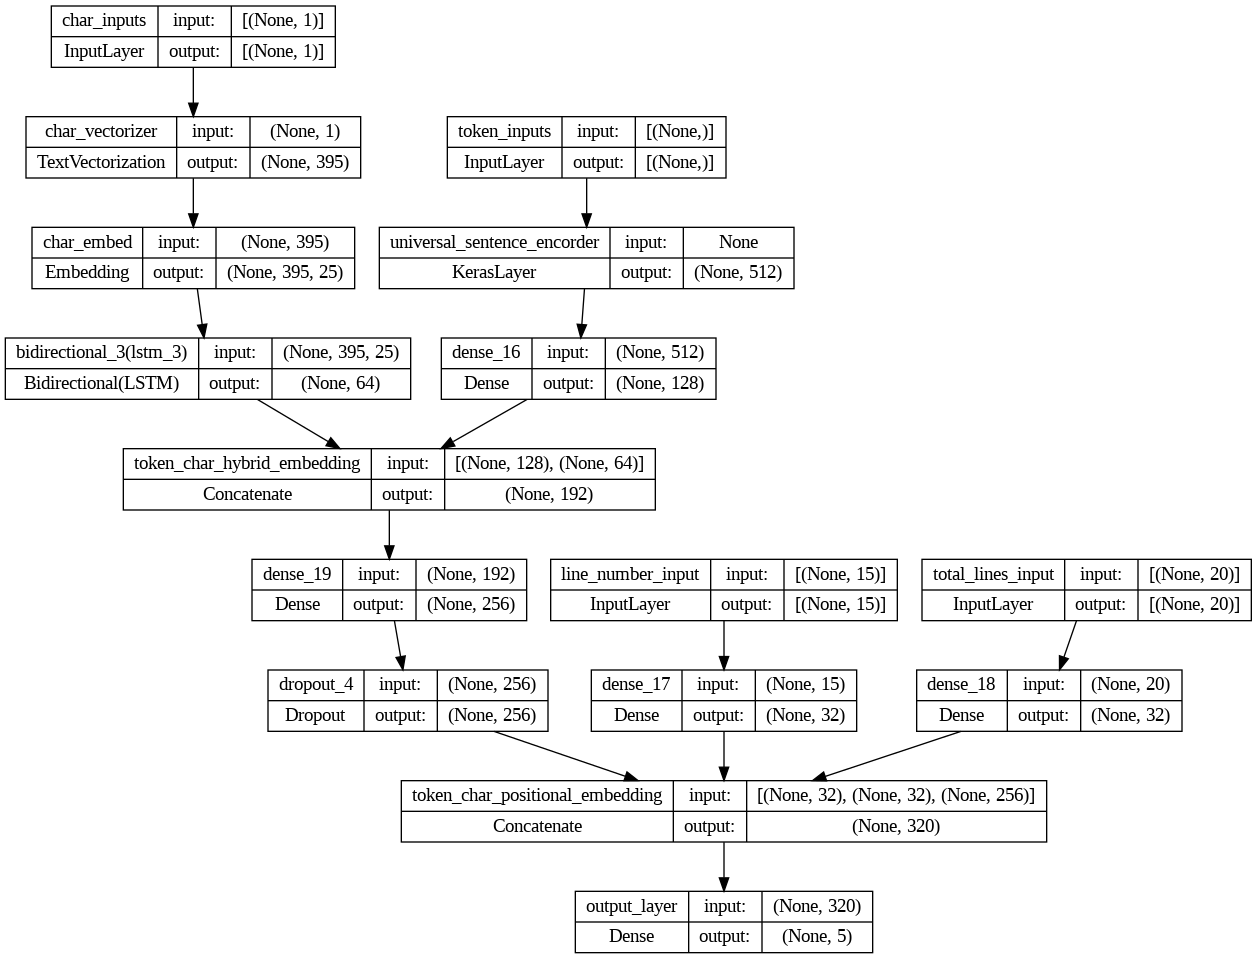

In [139]:
# Plot the model
plot_model(model_5, show_shapes=True)

In [140]:
# Compile the Model
model_5.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [142]:
# Create training and validation datasets (for all 4 kinds of inputs)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

# Use integer labels instead of one-hot encoded labels
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))

# Use integer labels instead of one-hot encoded labels
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [143]:
# Debugging: Print shapes of data
for data, label in train_char_token_pos_dataset.take(1):
    print("Data shapes:", [d.shape for d in data])
    print("Label shape:", label.shape)

Data shapes: [TensorShape([32, 15]), TensorShape([32, 20]), TensorShape([32]), TensorShape([32])]
Label shape: (32,)


In [147]:

# Define Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath="best_model_weights",
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_format='tf'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

# Train the Model
history = model_5.fit(
    train_char_token_pos_dataset,
    steps_per_epoch=int(0.3 * len(train_char_token_pos_dataset)),
    validation_data=val_char_token_pos_dataset,
    epochs=100,  # A high number, early stopping will stop training when no improvement
    validation_steps=int(0.3 * len(val_char_token_pos_dataset)),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
1687/1688 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8668
Epoch 1: val_loss improved from inf to 0.36525, saving model to best_model_weights
1688/1688 [==============================] - 109s 65ms/step - loss: 0.3508 - accuracy: 0.8669 - val_loss: 0.3653 - val_accuracy: 0.8539
Epoch 2/100
1687/1688 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8608
Epoch 2: val_loss improved from 0.36525 to 0.35313, saving model to best_model_weights
1688/1688 [==============================] - 102s 61ms/step - loss: 0.3712 - accuracy: 0.8609 - val_loss: 0.3531 - val_accuracy: 0.8621
Epoch 3/100
1687/1688 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8616
Epoch 3: val_loss did not improve from 0.35313
1688/1688 [==============================] - 96s 57ms/step - loss: 0.3694 - accuracy: 0.8615 - val_loss: 0.3557 - val_accuracy: 0.8643
Epoch 4/100
 563/1688 [=========>....................] - ETA: 1:00 - loss: 0.37


Epoch 4: val_loss improved from 0.35313 to 0.35110, saving model to best_model_weights
1688/1688 [==============================] - 54s 32ms/step - loss: 0.3744 - accuracy: 0.8585 - val_loss: 0.3511 - val_accuracy: 0.8606


In [148]:
# Make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 28s 22ms/step


array([[6.9296229e-01, 4.4069355e-04, 4.6044544e-05, 3.0641884e-01,
        1.3210684e-04],
       [6.9633782e-01, 9.5876062e-04, 3.8102581e-03, 2.9883301e-01,
        6.0190687e-05],
       [4.4107017e-01, 3.6287153e-04, 3.3463854e-02, 5.1996028e-01,
        5.1428201e-03],
       ...,
       [3.4288514e-06, 6.9335714e-04, 9.1388480e-05, 1.5812687e-07,
        9.9921167e-01],
       [2.7425159e-04, 3.7057537e-01, 4.6701645e-03, 6.6627590e-06,
        6.2447357e-01],
       [4.0052146e-02, 9.5062858e-01, 5.4226015e-03, 1.6551086e-04,
        3.7311565e-03]], dtype=float32)

In [149]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [150]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 86.52522176618562,
 'precision': 0.8668226961595814,
 'recall': 0.8652522176618562,
 'f1': 0.8627076417603033}

In [152]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [153]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.895009,0.806218,0.808950,0.805140
pretrained_token_embed,74.940421,0.744465,0.749404,0.744677
custom_char_embed_conv1d,71.514630,0.715195,0.715146,0.704191
hybrid_char_token_embed,76.234609,0.761216,0.762346,0.758188
tribrid_pos_char_token_embed,86.525222,0.866823,0.865252,0.862708


In [154]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


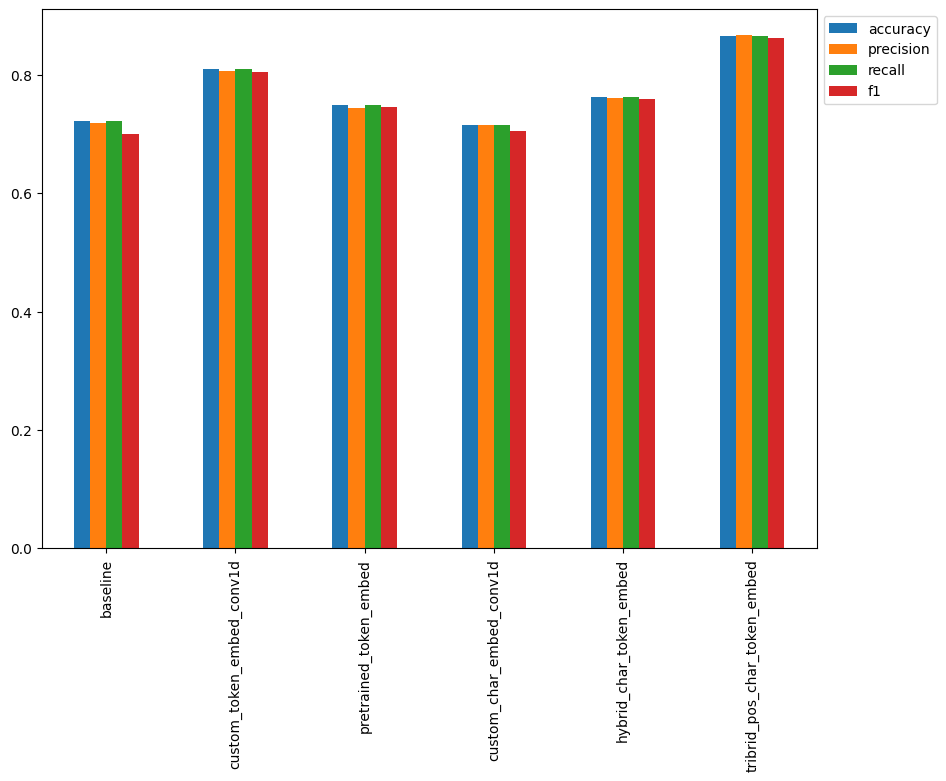

In [155]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


In [156]:
model_5.save("skimlit_tribrid_mode_with_callbacks_and_early_stoppings")

In [157]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [160]:
import shutil
import os

# Step 2: Define the source and destination paths
source_folder = '/content/skimlit_tribrid_mode_with_callbacks_and_early_stoppings'
destination_folder = '/content/drive/MyDrive/Tensorflow/skimlit_tribrid_mode_with_callbacks_and_early_stoppings'

# Step 3: Check if the destination folder already exists and remove it if necessary
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# Step 4: Copy the folder
shutil.copytree(source_folder, destination_folder)

# Verify the contents of the copied folder
print(f"Contents of {destination_folder}:")
print(os.listdir(destination_folder))


Contents of /content/drive/MyDrive/Tensorflow/skimlit_tribrid_mode_with_callbacks_and_early_stoppings:
['saved_model.pb', 'fingerprint.pb', 'keras_metadata.pb', 'assets', 'variables']
